# Quantum circuit design

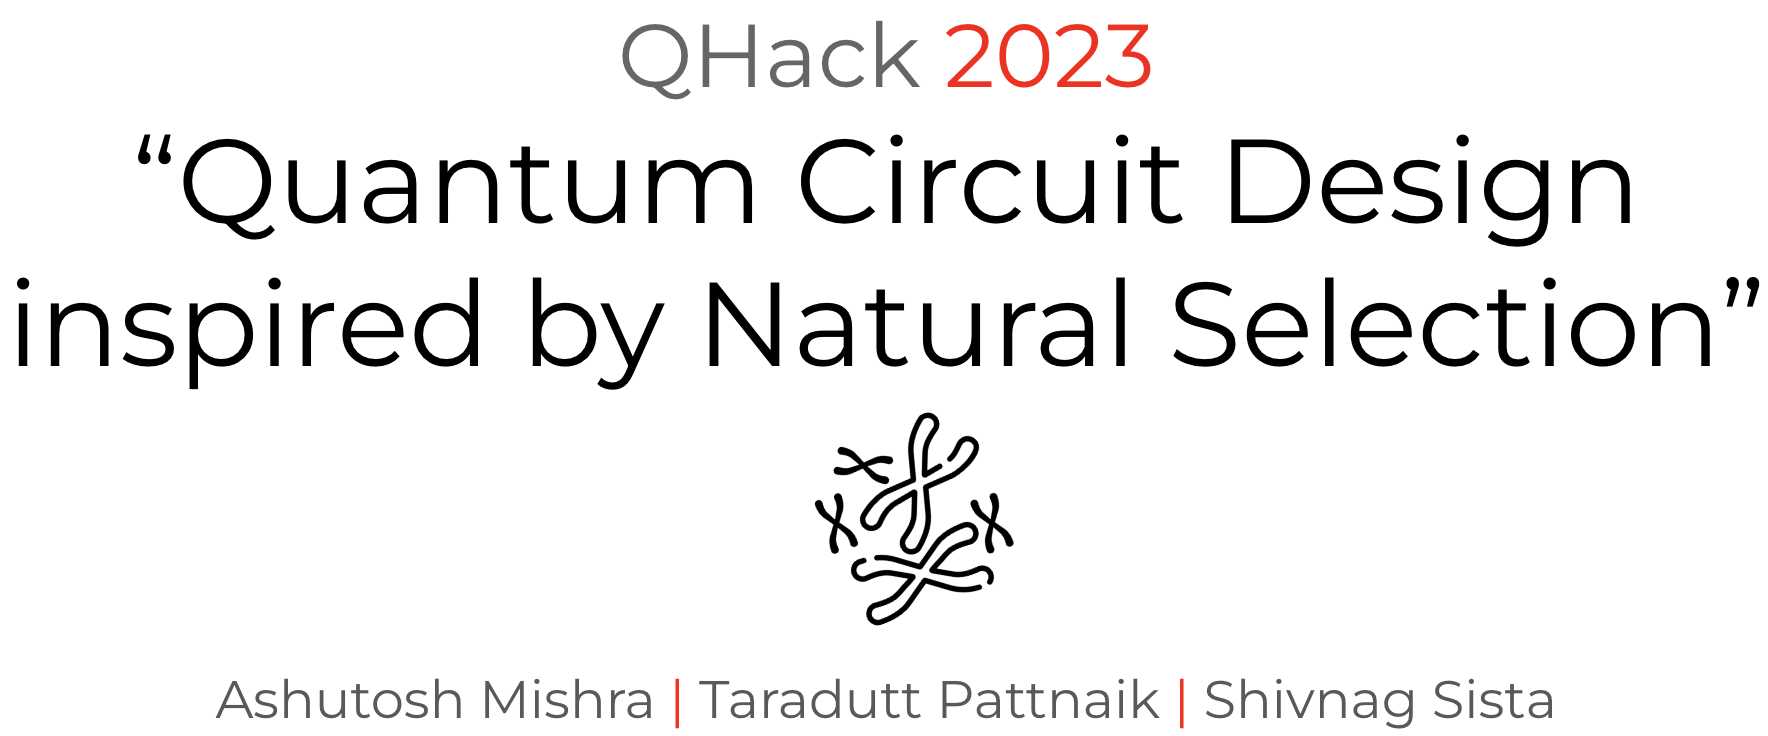

Here we design quantum circuits using genetic algorithms.

In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

import random
import copy

from helper_functions import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

psi_target = np.array([1, 0, 0, 0, 0, 0, 0, 0]) # |00> state


### 1. Generating a random circuit

In [3]:
def select_random_gate(basis_gates):
    """
    Returns one randomly selected gate from the list of `basis_gates`.
    The input parameters of the gate is also randomly choosen.

    Args:
        basis_gates (List[qml.operation.Operation]): _description_

    Returns:
        qml.operation.Operation: Random gate chosen from the basis set
    """
    gate = random.sample(basis_gates, 1)[0]
    if gate == qml.CNOT:
        return gate(wires=random.sample(range(n_qubits), 2))
    else:
        return gate(2*np.pi*random.random(), wires=random.sample(range(n_qubits),1))

def generate_random_circuit(n_gates):
    """
    Generates a random circuit with `n_gates` number of gates.

    Args:
        n_gates (int): Number of gates in the circuit

    Returns:
        qml.operation.Operation: Randomly generated circuit.
    """
    gates_list = []
    for i in range(n_gates):
        gates_list.append(select_random_gate(basis_gates))
    return gates_list

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

For example a random circuit with 5 gates would be something like - 

(<Figure size 432x288 with 1 Axes>, <Axes:>)

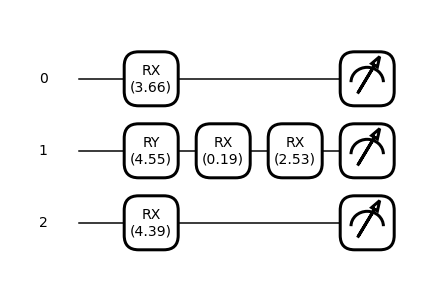

In [5]:
qml.draw_mpl(circuit_from_list, decimals=2)(generate_random_circuit(5))

### 2. Assess the fitness of the population

In [6]:
def compute_fitness(input, psi_target):
    """
    Compute the fitness of all individuals in the population.
    The fitness is calculated as the inner product of the state generated from an individual
    and the target state.

    Args:
        input (List[List[qml.operation.Operation]]): List of all circuits in the population
        psi_target (np.ndarray): Target state

    Returns:
        List: List of fitness of all individuals in the population
    """
    individuals = copy.deepcopy(input) # input is a list of individuals
    fitness_arr = []
    for i in individuals:
        fitness = inner_product(psi_target, circuit_from_list(i))
        fitness_arr.append(fitness)
    return fitness_arr

### 3. Offsprings - Crossover and Mutation

In [7]:
def population_crossover(input):
    """
    Perform crossover for the population.
    Here we select two individuals of the population and do a crossover to create a 
    new generation of individuals.
    This can should generate a population of nC2 individuals,
    but we consider a multiplicity is 2, ie, the population doubles after crossover.
    Since we also generate variability using mutation later we dont need to consider
    all possible combination.

    Args:
        input (List[List[qml.operation.Operation]]): List of all circuits in the population.

    Returns:
        List[List[qml.operation.Operation]]: New generation of individuals
    """
    individuals = copy.deepcopy(input) # input is the list of all individuals
    new_individuals = []
    for i in range(len(individuals)-1):
        temp_ind = crossover(individuals[i], individuals[i+1])
        new_individuals.append(temp_ind[0])
        new_individuals.append(temp_ind[1])

    temp_ind = crossover(individuals[-1], individuals[0])
    new_individuals.append(temp_ind[0])
    new_individuals.append(temp_ind[1])
    
    return new_individuals


def crossover(individual1, individual2):
    """
    Perform crossover for two individuals to create two new individuals.
    Here we add half of one circuit to second-half of other circuit to create new circuit. 

    Args:
        individual1 (List[qml.operation.Operation]): Individual 1
        individual2 (List[qml.operation.Operation]): Individual 2

    Returns:
        List[qml.operation.Operation], List[qml.operation.Operation]: Two new individuals
    """
    cutoff = int(np.floor(len(individual1)/2))
    new_ind1 = individual1[0:cutoff] +  individual2[cutoff:]
    new_ind2 = individual2[0:cutoff] + individual1[cutoff:]
    return new_ind1, new_ind2

def population_mutation(input, p=0.05):
    """
    Mutate the input population with some probability `p` to introduce variablitiy.

    Args:
        input (List[List[qml.operation.Operation]]): List of all circuits in the population
        p (float, optional): probabitlity of mutation. Defaults to 0.05.

    Returns:
        List[List[qml.operation.Operation]]: Muatated population
    """
    individuals_list = copy.deepcopy(input) # input is the list of all individuals
    new_individuals = []
    for i in individuals_list:
        new_individuals.append(mutation(i, p=p))
    return new_individuals


def mutation(individual, p):
    """
    Mutate the gates of one individual with probability p.

    Args:
        individual (List[qml.operation.Operation]): One individual circuit
        p (float): probability of mutation

    Returns:
        List[qml.operation.Operation]: Muatated individual
    """
    random_arr = np.random.rand(len(individual)) - p
    for i in range(len(individual)):
        if random_arr[i] < 0:
            individual = mutate(individual, i)
    return individual

def mutate(individual, pos):
    """
    Mutate the gate at position `pos`.
    For CNOT gate we flip the control and the target qubit.
    For Rotation gate we replace it with a random rotation gate.

    Args:
        individual (List[qml.operation.Operation]): One individual circuit
        pos (int): position of gate to be mutated

    Returns:
        List[qml.operation.Operation]: Individual mutated at position `pos`
    """
    if individual[pos].name == "CNOT":
        individual[pos] = qml.CNOT(wires=[individual[pos].wires[1], individual[pos].wires[0]])
    else:
        individual[pos] = select_random_gate(basis_gates2)
    return individual

### 4. Optimizing the individuals

In [8]:
def update_circuit(individual, params, positions):
    """
    Create a new individual using the updated parameters.

    Args:
        individual (List[qml.operation.Operation]): Input individual
        params (List[float]): New parameters of the circuit
        positions (List[int]): specifies what gate is at what position.
                                0  ->  CNOT
                                1  ->  RX
                                2  ->  RY
                                3  ->  RZ

    Returns:
        List[qml.operation.Operation]: Updated individual
    """
    updated_individual = []
    for i in range(len(params)):
        if positions[i] == 0: #CNOT
            updated_individual.append(qml.CNOT(wires=individual[i].wires))
        elif positions[i] == 1: #RX
            updated_individual.append(qml.RX(params[i], wires=individual[i].wires))
        elif positions[i] == 2: #RY
            updated_individual.append(qml.RY(params[i], wires=individual[i].wires))
        elif positions[i] == 3: #RZ
            updated_individual.append(qml.RZ(params[i], wires=individual[i].wires))
    return updated_individual

def optimize_circuit(individual, psi_target):
    """
    Optimize one individual to find the best fitness of the circuit.
    To do this, we need to deconstruct the circuit to find the parameters.
    Then we define a cost function (which is 1 - fitness) for optimization
    and then use an Adam optimizer to optimize the circuit.

    We select the top 50% of the optimized population for next step.


    Args:
        individual (List[qml.operation.Operation]): Individual
        psi_target (np.ndarray): Target state for calculating fitness

    Returns:
        List[qml.operation.Operation]: Optimized individual
    """

    # collect parameters from circuit
    params = [0]*len(individual)
    positions = [0]*len(individual)
    for i in range(len(individual)):
        if individual[i].name != "CNOT":
            params[i] = individual[i].parameters[0]
            if individual[i].name == "RX":
                positions[i] = 1
            elif individual[i].name == "RY":
                positions[i] = 2
            elif individual[i].name == "RZ":
                positions[i] = 3
    
    params = np.array(params, requires_grad=True)

    # Reconstruct the circuit from the parameters
    @qml.qnode(dev)
    def circuit(params):
        for i in range(len(params)):
            if positions[i] == 0: #CNOT
                qml.CNOT(wires=individual[i].wires)
            elif positions[i] == 1: #RX
                qml.RX(params[i], wires=individual[i].wires)
            elif positions[i] == 2: #RY
                qml.RY(params[i], wires=individual[i].wires)
            elif positions[i] == 3: #RZ
                qml.RZ(params[i], wires=individual[i].wires)

        return qml.state()

    # Define the cost function
    def cost(params):
        state = circuit(params)
        fitness = inner_product(psi_target, state)
        return 1 - fitness


    # Optimization
    opt = qml.AdamOptimizer(0.5)
    for i in range(100):
        params, prev_cost = opt.step_and_cost(cost, params)
        if i%99==0:
            print(f'Step: {i} ,Cost: {prev_cost}') 
    
    optimized_individual = update_circuit(individual, params, positions)

    return optimized_individual


def population_optimization(individuals, psi_target):
    """
    Optimization of the whole population.

    Args:
        individuals (List[List[qml.operation.Operation]]): Population
        psi_target (np.ndarray): Target state

    Returns:
        List[List[qml.operation.Operation]]: optimized population
    """
    optimized_individuals = []
    individuals_copy = copy.deepcopy(individuals)
    for i in individuals_copy:
        optimized_individuals.append(optimize_circuit(i, psi_target))
    return optimized_individuals


### 5. Running the algorithm

In [9]:
def add_gate(individual):
    """
    Add a random gate to an individual

    Args:
        individual (List[qml.operation.Operation]): Individual

    Returns:
        List[qml.operation.Operation]: updated individual
    """
    new_gate = generate_random_circuit(1)
    return individual + new_gate

def population_add_gate(individuals):
    """
    Add a random gate to every circuit in the population

    Args:
        individuals (List[List[qml.operation.Operation]]): Population of all individuals

    Returns:
        List[List[qml.operation.Operation]]: Updated population
    """
    new_individuals = [add_gate(i) for i in individuals]
    return new_individuals

In [10]:
def generate_circuits(psi_target, n=20, n_gates=2):
    """
    Quantum circuits constructed by using genetic algorithm.

    Args:
        psi_target (np.ndarray): Target state to be achieved
        n (int, optional): Number of individuals in each generation. Defaults to 20.
        n_gates (int, optional): Number of gates initially in the circuit. Defaults to 9.
    """

    finished_flag = False
    n_gates_intial = copy.deepcopy(n_gates)

    individuals = [] # List of randomly generated initial individuals
    for i in range(n):
        print(f"Generating circuit {i}")
        individuals.append(generate_random_circuit(n_gates))

    final_result = []

    print("Starting Genetic algorithm")
    while n_gates < MAX_GATES:
        print(f"Starting with gates {n_gates}")

        if n_gates != n_gates_intial:
            individuals = population_add_gate(individuals)

        n_iter = 1

        while n_iter < MAX_ITER:

            print(f"Iteration {n_iter} starting ...")


            fitnesses = compute_fitness(individuals, psi_target)
            # TODO - Assess fitness and check for termination
            for i, fit in enumerate(fitnesses):
                if fit >= 0.95:
                    finished_flag = True
                    final_result.append(individuals[i])
                    print("Found solution!!!")
                    print(f"Fitness = {fit}")

            if finished_flag:
                break

            # Crossover
            crossover_individuals = population_crossover(individuals)

            # Mutation of population
            mutated_individuals = population_mutation(crossover_individuals, p=0.2)

            # Angle optimization
            print("Starting optimization")
            optimized_individuals = population_optimization(mutated_individuals, psi_target)
            print("Finished optimization")


            # compute fitness and selection
            fitnesses_before_selection = compute_fitness(optimized_individuals, psi_target)

            sorted_indices = np.argsort(fitnesses_before_selection)

            # updating individuals
            individuals = [optimized_individuals[i] for i in sorted_indices[-n:]] 

            n_iter += 1

        
        if finished_flag:
            break

        # increasing the number of gates after MAX_ITER  
        n_gates += 1
        print(f"Increasing number of gates to {n_gates}")

    return final_result


### 6. Process results

In [11]:
def process_results(final_result):
    if len(final_result) > 1:
        print(f"Found {len(final_result)} circuits!")
    else:
        print(f"Found {len(final_result)} circuit!")

    for i in range(len(final_result)):
        print(qml.draw(circuit_from_list)(final_result[i]))
        qml.draw_mpl(circuit_from_list, decimals=2)(final_result[i])

# Results

## 1. Bell state $|\Phi^+\rangle$

In [12]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([1, 0, 0, 1])/np.sqrt(2) # |00> + |11> - bell state
psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

# reinitializing dev

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [13]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=10,
                    n_gates=2
)

Generating circuit 0
Generating circuit 1
Generating circuit 2
Generating circuit 3
Generating circuit 4
Generating circuit 5
Generating circuit 6
Generating circuit 7
Generating circuit 8
Generating circuit 9
Starting Genetic algorithm
Starting with gates 2
Iteration 1 starting ...
Starting optimization
Step: 0 ,Cost: 0.9862218657607318
Step: 99 ,Cost: 0.5000015276455105
Step: 0 ,Cost: 0.6509583529425069
Step: 99 ,Cost: 0.5000027817752684
Step: 0 ,Cost: 0.9946386492125048
Step: 99 ,Cost: 0.5000009138843207
Step: 0 ,Cost: 0.4999999999999998
Step: 99 ,Cost: 0.4999999999999999
Step: 0 ,Cost: 0.8730515463670306
Step: 99 ,Cost: 0.5000014731146383
Step: 0 ,Cost: 0.9946386492125048
Step: 99 ,Cost: 0.5000009138843207
Step: 0 ,Cost: 0.4999999999999999
Step: 99 ,Cost: 0.4999999999999999
Step: 0 ,Cost: 0.8267025915096207
Step: 99 ,Cost: 0.5000000846269556
Step: 0 ,Cost: 0.7619952526909317
Step: 99 ,Cost: 0.5000009507348648
Step: 0 ,Cost: 0.10826026840358483
Step: 99 ,Cost: 2.206918434777272e-06


Found 1 circuit!
0: ───────────╭X─┤  State
1: ──RY(1.57)─╰●─┤  State


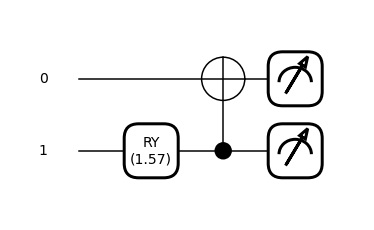

In [14]:
process_results(final_result)

In [15]:
qml_to_qasm(final_result[0])

ry(1.57) q[1];
cx q[1], q[0];


## 2. Bell State $|\Phi^-\rangle$

In [16]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([1, 0, 0, -1])/np.sqrt(2) # |00> - |11> - bell state

psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [17]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=10,
                    n_gates=2
)

Generating circuit 0
Generating circuit 1
Generating circuit 2
Generating circuit 3
Generating circuit 4
Generating circuit 5
Generating circuit 6
Generating circuit 7
Generating circuit 8
Generating circuit 9
Starting Genetic algorithm
Starting with gates 2
Iteration 1 starting ...
Starting optimization
Step: 0 ,Cost: 0.9805927685129695
Step: 99 ,Cost: 0.5000040451762278
Step: 0 ,Cost: 0.528121895812114
Step: 99 ,Cost: 0.5000004433637644
Step: 0 ,Cost: 0.9881855456538059
Step: 99 ,Cost: 0.5000032764538065
Step: 0 ,Cost: 0.6607290596467357
Step: 99 ,Cost: 0.5000038258485076
Step: 0 ,Cost: 0.4999999999999999
Step: 99 ,Cost: 0.4999999999999999
Step: 0 ,Cost: 0.8492644104278877
Step: 99 ,Cost: 0.5000001508966605
Step: 0 ,Cost: 0.9885434023099517
Step: 99 ,Cost: 0.5000031529233189
Step: 0 ,Cost: 0.5198849333034703
Step: 99 ,Cost: 0.5000001390603559
Step: 0 ,Cost: 0.8119478762228963
Step: 99 ,Cost: 0.5000048467724737
Step: 0 ,Cost: 0.9885434023099517
Step: 99 ,Cost: 0.5000031529233189
Step:

Found 1 circuit!
0: ───────────╭X─┤  State
1: ──RY(4.71)─╰●─┤  State


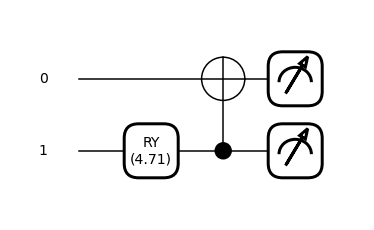

In [18]:
process_results(final_result)

In [19]:
qml_to_qasm(final_result[0])

ry(4.71) q[1];
cx q[1], q[0];


## 3. 3-Qubit GHZ state

In [20]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([1, 0, 0, 0, 0, 0, 0, 1])/np.sqrt(2) # |000> + |111> = GHZ state
psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [21]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=10,
                    n_gates=3
)

Generating circuit 0
Generating circuit 1
Generating circuit 2
Generating circuit 3
Generating circuit 4
Generating circuit 5
Generating circuit 6
Generating circuit 7
Generating circuit 8
Generating circuit 9
Starting Genetic algorithm
Starting with gates 3
Iteration 1 starting ...
Starting optimization
Step: 0 ,Cost: 0.8739757869469525
Step: 99 ,Cost: 0.5000016159395739
Step: 0 ,Cost: 0.989675992607959
Step: 99 ,Cost: 0.500002754091972
Step: 0 ,Cost: 0.992677647348921
Step: 99 ,Cost: 0.5000067941864292
Step: 0 ,Cost: 0.520048464010055
Step: 99 ,Cost: 0.5000000767285815
Step: 0 ,Cost: 0.7037962995371094
Step: 99 ,Cost: 0.5000021774909927
Step: 0 ,Cost: 0.6468157993506071
Step: 99 ,Cost: 0.5000006037294553
Step: 0 ,Cost: 0.5321472200862261
Step: 99 ,Cost: 0.5000011631840877
Step: 0 ,Cost: 0.4999999999999999
Step: 99 ,Cost: 0.4999999999999999
Step: 0 ,Cost: 0.9730700958255404
Step: 99 ,Cost: 0.5000091207685831
Step: 0 ,Cost: 0.5495358588767795
Step: 99 ,Cost: 0.5000000243153415
Step: 0 

Found 1 circuit!
0: ───────╭X────────╭X─╭●─┤  State
1: ─╭X─╭●─╰●────────│──╰X─┤  State
2: ─╰●─╰X──RY(1.58)─╰●────┤  State


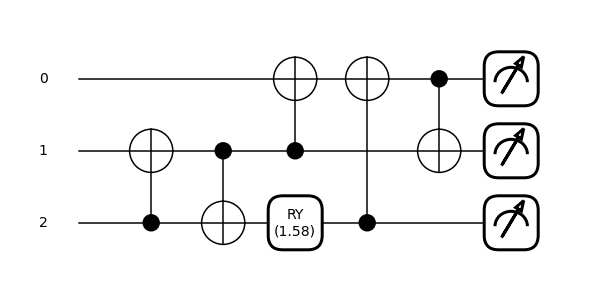

In [22]:
process_results(final_result)

In [23]:
qml_to_qasm(final_result[0])

cx q[2], q[1];
cx q[1], q[2];
cx q[1], q[0];
ry(1.58) q[2];
cx q[2], q[0];
cx q[0], q[1];


## 4. 3-Qubit W state

In [31]:
MAX_GATES = 13
MAX_ITER = 25

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([0, 1, 1, 0, 1, 0, 0, 0])/np.sqrt(3) # W state
psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]


@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [32]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=20,
                    n_gates=9
)

Generating circuit 0
Generating circuit 1
Generating circuit 2
Generating circuit 3
Generating circuit 4
Generating circuit 5
Generating circuit 6
Generating circuit 7
Generating circuit 8
Generating circuit 9
Generating circuit 10
Generating circuit 11
Generating circuit 12
Generating circuit 13
Generating circuit 14
Generating circuit 15
Generating circuit 16
Generating circuit 17
Generating circuit 18
Generating circuit 19
Starting Genetic algorithm
Starting with gates 9
Iteration 1 starting ...
Starting optimization
Step: 0 ,Cost: 0.9762023429955881
Step: 99 ,Cost: 0.33334154999601406
Step: 0 ,Cost: 0.7759401014312108
Step: 99 ,Cost: 0.6666668035406818
Step: 0 ,Cost: 0.6717817509569104
Step: 99 ,Cost: 0.6666667261157301
Step: 0 ,Cost: 0.9878125069815957
Step: 99 ,Cost: 0.33333644211886193
Step: 0 ,Cost: 0.6691532960699038
Step: 99 ,Cost: 0.3333342446053186
Step: 0 ,Cost: 0.8586690293529191
Step: 99 ,Cost: 0.6666675778119522
Step: 0 ,Cost: 0.7199621055666545
Step: 99 ,Cost: 0.555560

Found 1 circuit!
0: ───────────╭X──RZ(3.15)───RY(2.29)──RY(5.10)─╭●──────────────┤  State
1: ──RY(5.56)─╰●──RY(-4.25)─────────────────────│──╭●──RX(3.14)─┤  State
2: ─────────────────────────────────────────────╰X─╰X───────────┤  State


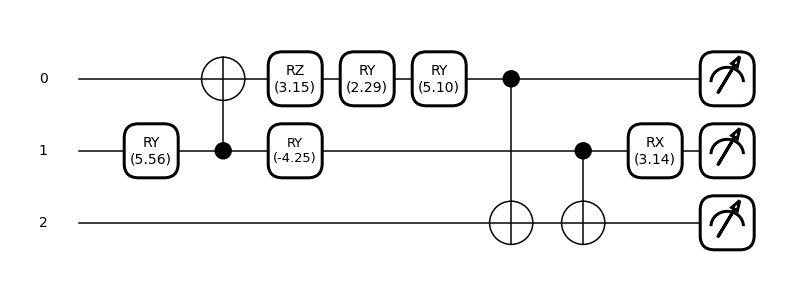

In [37]:
process_results(final_result)

In [35]:
qml_to_qasm(final_result[0])

ry(5.56) q[1];
cx q[1], q[0];
ry(-4.25) q[1];
rz(3.15) q[0];
ry(2.29) q[0];
ry(5.1) q[0];
cx q[0], q[2];
cx q[1], q[2];
rx(3.14) q[1];
